## DSE 200 Matplotlib Extras

Creating custom visualizations for your data. Here, we create radial plots that represent how many standard deviations away from the mean a given sample is. 

The radial plot code was adapted from <a href="https://python-graph-gallery.com/390-basic-radar-chart/">this example</a>.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi

%matplotlib inline

### Step 1: Get the data and clean it

In [25]:
data = pd.read_csv('./daily_weather.csv')

# count samples with NaN values, then drop them
num_nan_samples = len(data[data.isnull().any(axis=1)])
data = data[~data.isnull().any(axis=1)]

# Drop the columns that we aren't interested in plotting
data.drop('relative_humidity_3pm', axis=1, inplace=True)
data.drop('rain_accumulation_9am', axis=1, inplace=True)

# Reindex and print some stuff
data.set_index('number', drop=True, inplace=True)
print('Dataset has {} samples, each with {} features'.format(data.shape[0], data.shape[1]-1))
print('{} samples with NaN values were dropped'.format(num_nan_samples))
data.head()

Dataset has 1064 samples, each with 7 features
31 samples with NaN values were dropped


,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_duration_9am,relative_humidity_9am
number,,,,,,,,
0,918.060000,74.822000,271.100000,2.080354,295.400000,2.863283,0.0,42.420000
1,917.347688,71.403843,101.935179,2.443009,140.471548,3.533324,0.0,24.328697
2,923.040000,60.638000,51.000000,17.067852,63.700000,22.100967,20.0,8.900000
3,920.502751,70.138895,198.832133,4.337363,211.203341,5.190045,0.0,12.189102
4,921.160000,44.294000,277.800000,1.856660,136.500000,2.863283,14730.0,92.410000


### Step 2: Transform the values in each column to a standard normal distribution

This way, we don't have to worry about how the ranges of values vary by unit of measurement.<br><br>
We're only interested in the relative values in each column, so we transform our dataset so that a given value represents how far off from the mean that measurement is (in the number of standard deviations)<br><br>
For a given column, this can be accomplished by subtracting the column's mean and dividing by the column's standard deviation.<br>
`column = (column - column_mean) / column_std_dev`<br>
Notice that for values close to the mean, applying this process results in transformed values being close to 0.

In [26]:
# Normalize values for plotting
for column in data:
    stddev = data[column].std()
    mean = data[column].mean()    
    print(column, stddev, mean)
    data[column] -= mean
    data[column] /= stddev
    
data.head()

air_pressure_9am 3.1790395342048297 918.9031798641056
air_temp_9am 11.168033449415695 65.02260949558739
avg_wind_direction_9am 69.14947215860062 142.30675564934035
avg_wind_speed_9am 4.534427253459236 5.485793050713691
max_wind_direction_9am 67.15491055520597 148.4804241332132
max_wind_speed_9am 5.590789883333876 6.999713658875692
rain_duration_9am 1503.0922161525934 266.3936973996038
relative_humidity_9am 25.356668120008766 34.0774398532771


,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_duration_9am,relative_humidity_9am
number,,,,,,,,
0,-0.265231,0.877450,1.862534,-0.751019,2.187771,-0.739865,-0.177230,0.329009
1,-0.489296,0.571384,-0.583831,-0.671040,-0.119260,-0.620018,-0.177230,-0.384465
2,1.301280,-0.392604,-1.320426,2.554250,-1.262461,2.701095,-0.163925,-0.992932
3,0.503162,0.458119,0.817438,-0.253269,0.934003,-0.323687,-0.177230,-0.863218
4,0.709906,-1.856066,1.959426,-0.800351,-0.178400,-0.739865,9.622567,2.300482


### Step 3: Define a function for plotting a sample

This function will plot feature values on a radial plot. A radial plot is ideal here for a few reasons.<br>
We can view each data sample as a vector in 7-dimensional space, something that is impossible for the human mind to visualize. The radial plot conveniently presents these vectors as geometric shapes, which are much more human-interpretable.<br>Additionally, the negative values (see step 2) in our features make our dataset less ameanable to more typical visualization approaches.<br>


In [68]:
def plot_sample(values, feature_names, y_range=np.arange(-3,4)):

    # Divide the circumference of the plot with N equally spaced grid lines
    N = len(feature_names)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    fig = plt.figure(1, figsize=(4,4), dpi=120)
    ax = plt.subplot(111, polar=True)
    ax.spines['polar'].set_visible(False)   

    # Draw one axis per variable + add labels 
    plt.xticks(angles[:-1], feature_names, color='black', size=8, )

    # Draw ylabels
    ax.set_rlabel_position(22.5)
    plt.yticks(y_range, y_range, color='black', size=8, weight='normal')
    plt.ylim(y_range[0], y_range[-1])
    
    # Make the line corresponding to 0 stand out
    zero_mean_line = (-1 * y_range[0]) + 1 # figure out which line is 0 using lowest negative value
    gridlines = ax.get_ygridlines()
    gridlines[zero_mean_line].set_linewidth(2)
    gridlines[zero_mean_line].set_linestyle('--')
    gridlines[zero_mean_line].set_color('#96beff')

    # Plot the values from our sample
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1);



### Step 4: Pick an interesting weather sample to plot
Lets look at the more extreme weather samples. 

#### 4a: Rainy Conditions

Let's see how other features compare to rain duration on rainy days<br><br>
First, let's sort the DataFrame on nonincreasing rainfall for convenience.

In [69]:
weather_df = data.copy() # work with a copy of the original dataframe, trust me.

# Print mins and maxes to check our intuition when plotting and to help us pick our ranges
print('In number of standard devations away from the mean rain duration:')
print('Max rain duration: {}\nMin rain duration: {}'.format(weather_df['rain_duration_9am'].max(),
                                                            weather_df['rain_duration_9am'].min()))
print('In number of standard devations away from the mean air pressure:')
print('Max air pressure: {}\nMin air pressure: {}'.format(weather_df['air_pressure_9am'].max(),
                                                            weather_df['air_pressure_9am'].min()))
      
weather_df = weather_df.sort_values(by=['rain_duration_9am'], ascending=False, inplace=False)
weather_df.head()

In number of standard devations away from the mean rain duration:
Max rain duration: 11.601155348428827
Min rain duration: -0.17723044171001123
In number of standard devations away from the mean air pressure:
Max air pressure: 3.276719280718584
Min air pressure: -3.4328544035652904


,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_duration_9am,relative_humidity_9am
number,,,,,,,,
565,-2.844626,-0.974443,0.251531,2.919309,0.586995,3.125213,11.601155,2.205438
438,-0.941536,-2.073652,0.267439,-0.568489,-0.976554,-0.411774,10.367033,2.268538
984,0.930099,-2.366989,0.977495,-0.420492,0.353207,-0.475791,10.334433,1.882840
4,0.709906,-1.856066,1.959426,-0.800351,-0.178400,-0.739865,9.622567,2.300482
687,-2.048789,-2.104275,-1.547470,-0.361293,-1.459021,-0.435780,9.364433,2.076872


Now, pick a sample from the sorted DataFrame and plot it

[-2.8446264246783652, -0.9744427740910289, 0.25153112247576825, 2.9193091010970376, 0.5869946894558232, 3.125213128329059, 11.601155348428827, 2.2054380284527717]


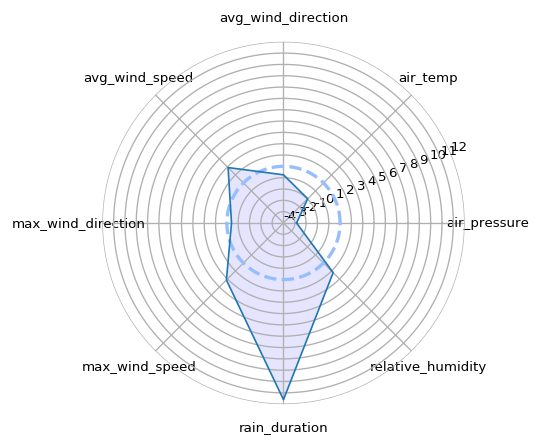

In [70]:
i = 0 # which sample in sorted df to select

# Get a list of floats from the Series and repeat last element to close the radial plot
values = weather_df.iloc[i].values.flatten().tolist()
print(values)

values += values[:1]

# Get feature names as a list of strings 
features = [f.replace('_9am', '') for f in list(weather_df)]

plot_sample(values=values, feature_names=features, y_range=np.arange(-4, 13))

#### 3b: Santa Ana Conditions
**Santa Ana conditions** are hot, dry, windy weather conditions that greatly increase the dangers of wildfires in Southern California. These winds typically blow towards the coast from mountain passes to the North-East.

<img src='./img/santa_ana_winds.jpg' length=300 width=300 align='left' alt_text='Santa Ana Winds'>

In [71]:
weather_df = data.copy() # work with a copy of the original dataframe, trust me.

# Print mins and maxes to check our intuition when plotting
print('In number of standard devations away from the mean:')
print('Max rel humidity: {}\nMin rel humidity: {}'.format(weather_df['relative_humidity_9am'].max(),
                                                          weather_df['relative_humidity_9am'].min()))
print('Max avg wind speed: {}\nMin avg wind speed: {}'.format(weather_df['avg_wind_speed_9am'].max(),
                                                              weather_df['avg_wind_speed_9am'].min()))
print('Max avg wind direction: {}\nMin avg wind direction: {}'.format(weather_df['avg_wind_direction_9am'].max(),
                                                                      weather_df['avg_wind_direction_9am'].min()))

# sort weather data to put Santa Ana-like samples at the top 
weather_df = weather_df.sort_values(['avg_wind_speed_9am',
                                     'avg_wind_direction_9am',
                                     'relative_humidity_9am'],
                                    ascending=[False, True, True],
                                    inplace=False)
weather_df.head()

In number of standard devations away from the mean:
Max rel humidity: 2.308763906584698
Min rel humidity: -1.1037506868337879
Max avg wind speed: 3.9848880882368123
Min avg wind speed: -1.0568791564707445
Max avg wind direction: 2.9080951462569944
Min avg wind direction: -1.8338065597738398


,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_duration_9am,relative_humidity_9am
number,,,,,,,,
97,0.829439,-1.957606,-1.298734,3.984888,-1.198429,4.085481,-0.110701,-0.579628
496,0.338934,-0.083319,-1.306378,3.662191,-1.118734,3.673067,-0.093997,-0.845156
671,0.775964,-0.361980,-1.443348,3.540897,-1.412859,3.333271,-0.143966,-0.871465
941,0.473986,0.086084,-1.333441,3.535964,-1.284797,3.317267,-0.150619,-0.859239
926,0.439437,0.172860,-1.345899,3.513653,-1.275818,3.365520,-0.151765,-0.830108


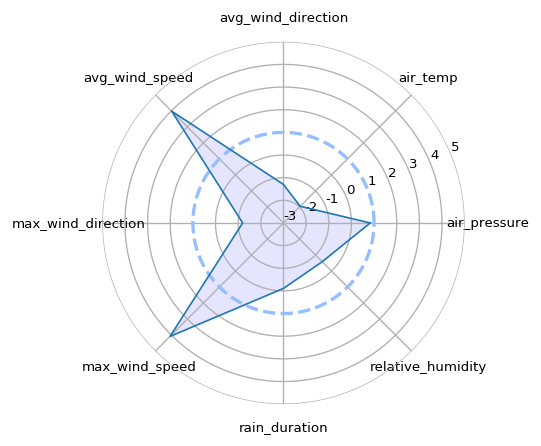

In [74]:
i = 0
values = weather_df.iloc[i].values.flatten().tolist()
values += values[:1] # must repeat last element to close the radial plot

weather_df.loc[i]

# Get feature names as a list of strings 
features = [f.replace('_9am', '') for f in list(weather_df)]
plot_sample(values=values, feature_names=features, y_range=np.arange(-3,6))